<img src="../figures/banner.png" alt="banner" class="center" style="max-width: 90%">

# Preprocessing

The purpose of this notebook is to build the dataset for the model considering the results of the exploratory data analysis, and also to build and test the preprocessing functions that will be used in the machine learning pipeline.

## Table of contents

[1. Setup and data aquisition](#setup-and-data-aquisition)

[2. Dataset definition for machine learning](#dataset-definition)

[3. Preprocessing functions test](#function-tests)

## 1. Setup and data aquisition <a class="anchor" id="setup-and-data-aquisition"></a>

* This notebook runs in a `ml.m5.xlarge` instance with (2vCPU and 8 GiB RAM)

In [3]:
!pip install psycopg2-binary sqlalchemy-redshift sqlalchemy
!pip install seaborn==0.11.2
!pip install plotnine==0.8.0
!pip install pandas_bokeh 
!pip install pyarrow
!pip install fastparquet

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached psycopg2_binary-2.9.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Using cached sqlalchemy_redshift-0.8.9-py2.py3-none-any.whl (36 kB)
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using ca

In [4]:
# Code snippet to reload python scripts
%load_ext autoreload
%autoreload 2

In [5]:
# Load the libraries
from sqlalchemy import create_engine
import boto3
import json

import pandas as pd
import numpy as np

from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_bokeh                               # This is Pandas-bokeh
#pd.set_option('plotting.backend', 'pandas_bokeh') # This is Pandas-bokeh
pandas_bokeh.output_notebook() # https://github.com/PatrikHlobil/Pandas-Bokeh


# Configure pandas output
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

Loading BokehJS ...

* Download data from redshift

In [6]:
# Credentials
secretsmanager = boto3.client("secretsmanager")
secret = secretsmanager.get_secret_value(SecretId="dante_ruiz/redshift/user")
cred = json.loads(secret["SecretString"])
user_name = cred["username"]
user_pw = cred["password"]

# Redshift
redshift_cluster_identifier = "sdlf-cntcar-redshift-dev"
redshift_host = "sdlf-cntcar-redshift-dev.capkkn406tig.us-east-2.redshift.amazonaws.com"
database_name_redshift = "conectcar"
redshift_port = "5439"
schema_redshift = "cntcar_work"
table_name = ""

# Setup redshift connection
connection_string = "redshift+psycopg2://%s:%s@%s:%s/%s" % (user_name,user_pw,redshift_host,redshift_port,database_name_redshift)
engine = create_engine(connection_string)

/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release


In [11]:
%%time
query = '''
    SELECT * 
    FROM cntcar_ds_work.v02_customer_union;'''
df_customer_data = pd.read_sql( query, engine)

CPU times: user 31.6 s, sys: 1.45 s, total: 33.1 s
Wall time: 38.7 s


In [8]:
# Save the data locally to SageMaker storage
#df_last_transaction.to_parquet("../data/raw/input.parquet", index = False)

In [9]:
# Load data from sagemaker storage
#df_last_transaction = pd.read_parquet("../data/raw/input.parquet")
#df_customer_data = pd.read_parquet("../data/raw/input.parquet")

## 2. Dataset definition for machine learning <a class="anchor" id="dataset-definition"></a>

* Based on the literature review of credit scoring and the exploratory analysis, on our data we need to restrict the universe of customers to:
    - Filters: 
        + Use a recent period of information 2019, 2020 and 2021. Using the entire history of ConectCar is not convenient, as there are many customers who are no longer in the company and left with a debt.
        + Restrict customers with last transactions that took place in the same period of 2019, 2020 and 2021.
        + Only customers that have had a loan during  2019, 2020, 2021, because for the rest we do not know how they behave.


* Target variable definition:
    - Credit score model implies, customer defaulted on last credit or did not defaulted on last credit.
    - Based on average days payback we can define the target as:
        + **Not Default**: `avgdayspayback` <= 15
        + **Defaulted**: `avgdayspayback` > 15

In [12]:
df_model_data = (df_customer_data   
    .assign(has_had_a_loan = lambda df_: [False if np.isnan(val) else True for val in df_.totalloans],
            is_avgdayspayback_null = lambda df_: [True if np.isnan(val) else False for val in df_.avgdayspayback],
            defaulted_last_transaction = lambda df_: [True if val > 15 else False for val in df_.daysowningloan],
            defaulted_on_average = lambda df_: [True if val > 15 else False for val in df_.avgdayspayback]
            )
    .query('has_had_a_loan == True and is_avgdayspayback_null == False')
    .filter([
        'clienteid', 
        'vehicletype', 
        'doesstillhasdebit', 
        'customerage', 
        'sexoid', 
        'estadocivilid', 
        'estado', 
        'nomeplano',
        'pessoa_fisica',
        'totalloans', 
        'totalloans_highway', 
        'totaloans_parkinglot',
        'totalloans_membershipsubscription', 
        'totatransactions_parkinglot', 
        'avaragebalance', 
        'avaragerecharge',
        'avgdayspayback',
        'defaulted_on_average'])

)

df_model_data.head(10)

,clienteid,vehicletype,doesstillhasdebit,customerage,sexoid,estadocivilid,estado,nomeplano,pessoa_fisica,totalloans,totalloans_highway,totaloans_parkinglot,totalloans_membershipsubscription,totatransactions_parkinglot,avaragebalance,avaragerecharge,avgdayspayback,defaulted_on_average
1,40079,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,43.0,1.0,2.0,São Paulo,Básico,True,1.0,1.0,0.0,0.0,2,64.35,96.00,35.0,True
15,961,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,48.0,1.0,2.0,São Paulo,Básico,True,1.0,1.0,0.0,0.0,0,53.22,70.00,201.0,True
21,129069,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,59.0,1.0,2.0,Santa Catarina,Básico,True,1.0,1.0,0.0,0.0,1,54.64,85.71,0.0,False
33,471894,Pesado,HAD NO DEBITS ON HIS LAST TRANSACTION,48.0,1.0,2.0,São Paulo,Básico,True,1.0,1.0,0.0,0.0,0,153.01,262.50,0.0,False
37,515271,Leve,NO,53.0,1.0,5.0,Distrito Federal,Autocarga,True,25.0,25.0,0.0,0.0,0,69.28,222.00,32.0,True
42,137363,Leve,YES,42.0,1.0,1.0,São Paulo,Básico,True,2.0,2.0,0.0,0.0,1,45.23,57.27,0.0,False
48,15517,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,43.0,1.0,2.0,São Paulo,Básico,True,3.0,3.0,0.0,0.0,1,65.70,112.50,70.0,True
54,39003,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,52.0,1.0,2.0,São Paulo,Autocarga,True,8.0,6.0,0.0,0.0,0,84.24,151.66,7.0,False
61,273392,Leve,NO,36.0,1.0,1.0,São Paulo,Básico,True,3.0,3.0,0.0,0.0,0,17.94,50.00,203.0,True
67,363801,Leve,HAD NO DEBITS ON HIS LAST TRANSACTION,60.0,1.0,2.0,São Paulo,Flex,True,2.0,2.0,0.0,0.0,0,36.49,50.00,1.0,False


* Shape of the final dataset

In [13]:
# Print shape of the dataframe
df_model_data.shape

(154948, 18)

* Checking for null values:

In [14]:
# Checking missing values
df_model_data.isna().mean().round(2)

clienteid                            0.00
vehicletype                          0.03
doesstillhasdebit                    0.00
customerage                          0.03
sexoid                               0.03
estadocivilid                        0.18
estado                               0.00
nomeplano                            0.00
pessoa_fisica                        0.00
totalloans                           0.00
totalloans_highway                   0.00
totaloans_parkinglot                 0.00
totalloans_membershipsubscription    0.00
totatransactions_parkinglot          0.00
avaragebalance                       0.00
avaragerecharge                      0.03
avgdayspayback                       0.00
defaulted_on_average                 0.00
dtype: float64

* Looking at the distribution of average payback days.

    - The redline is the 15 day cutting threshold.

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 159'. Pick better value with 'binwidth'.


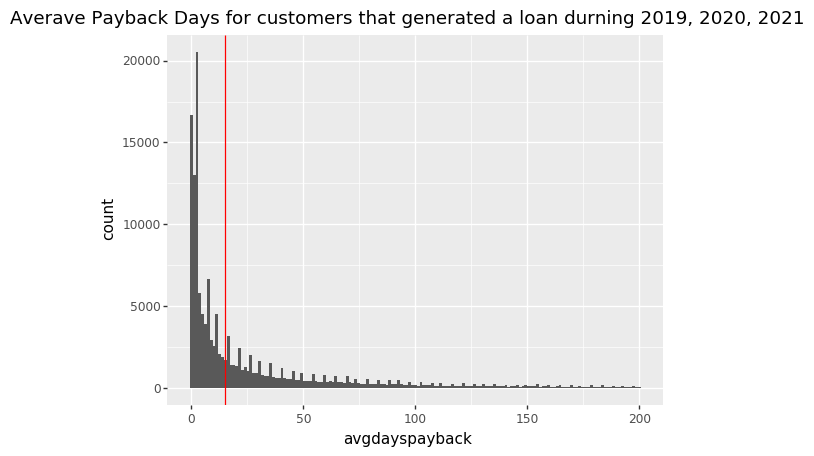

<ggplot: (8746172023925)>

In [15]:
(ggplot(df_model_data
            .query('avgdayspayback <= 200'), 
        aes( x = 'avgdayspayback')) 
 + geom_histogram()
 + geom_vline(xintercept=15, color = 'red')
 + labs(title = "Averave Payback Days for customers that generated a loan durning 2019, 2020, 2021"))

* Summary of customers based on 15 day cutting threshold.

In [16]:
tbl_class_distribution = (df_model_data
     .groupby('defaulted_on_average')
     .size()
     .reset_index(name = 'n_customers')
     .assign(pct = lambda df_: np.round(df_.n_customers / df_.n_customers.sum() * 100, 1)))
tbl_class_distribution

,defaulted_on_average,n_customers,pct
0,False,86892,56.1
1,True,68056,43.9


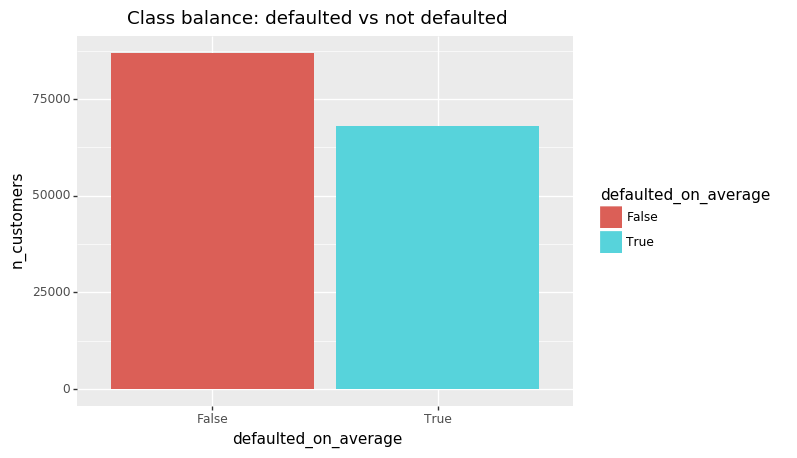

<ggplot: (8746288639661)>

In [17]:
(ggplot(tbl_class_distribution, 
        aes( x = 'defaulted_on_average', y = 'n_customers', fill = 'defaulted_on_average')) 
 + geom_col() 
 + labs( title = 'Class balance: defaulted vs not defaulted'))

**Observations**

* This is going to be an unbalanced classification problem, it looks ok.

## 3. Preprocessing

In this section we are going to test the `transformers.py` functions that will be used in the ML pipeline to transform data.

In this regard first we need to load the the python script that is located in the same notebook directory.

In [18]:
from transformers import *

Then we test how each function works, and make any adjustments necesary.

### 3.1 vehicletype

* This function imputes missing values as the majority class leve.

In [19]:
fun_clean_vehicletype(df_model_data['vehicletype'], replace_method = 'most_common').value_counts()

vehicletype
leve           143950
pesado          10998
dtype: int64

In [20]:
fun_clean_vehicletype(df_model_data['vehicletype'], replace_method = 'missing').value_counts()

vehicletype
leve           139154
pesado          10998
missing          4796
dtype: int64

### 3.2 customerage

- Needs imputation of nan values
- Needs to clip ages greater than 76 years

In [22]:
fun_clean_customerage(df_model_data['customerage'].dropna())

,customerage
1,43.0
15,48.0
21,59.0
33,48.0
37,53.0
...,...
1015051,29.0
1015052,71.0
1015053,39.0
1015064,40.0


/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 187'. Pick better value with 'binwidth'.


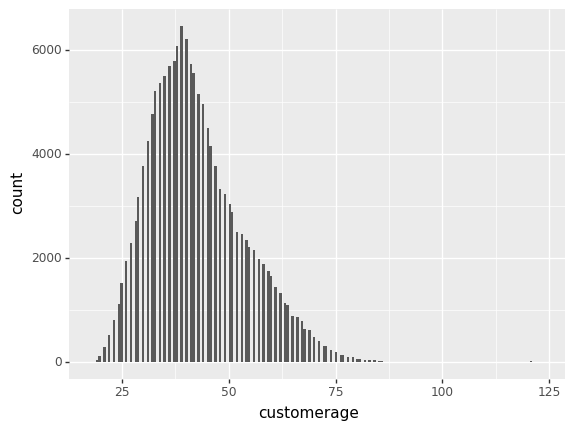

<ggplot: (8746293461293)>

In [24]:
(ggplot(df_model_data[['customerage']].dropna(), aes( x = 'customerage')) + geom_histogram())

/opt/conda/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 103'. Pick better value with 'binwidth'.


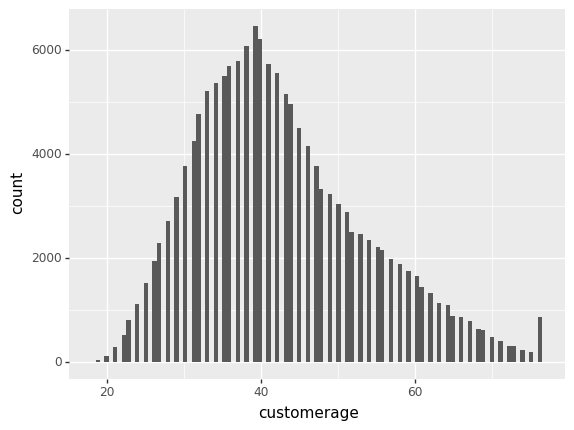

<ggplot: (8746279642721)>

In [26]:
(ggplot(fun_clean_customerage(df_model_data['customerage'].dropna()), aes( x = 'customerage')) + geom_histogram())

### 3.3 sexoid

* This function imputes missing values and relabels categories. 

In [30]:
fun_clean_sexoid(df_model_data['sexoid'], replace_method = 'most_common').value_counts()

sexoid
male      122395
female     32553
dtype: int64

In [31]:
fun_clean_sexoid(df_model_data['sexoid'], replace_method = 'missing').value_counts()

sexoid 
male       117890
female      32553
missing      4505
dtype: int64

### 3.4 estadocivilid

* This function imputes missing values and relabels categories. (1 is single and 2 is married)

In [40]:
df_model_data['estadocivilid'].value_counts()

2.0    76613
1.0    39820
4.0     6962
3.0     1842
5.0     1086
Name: estadocivilid, dtype: int64

In [33]:
fun_clean_estadocivilid(df_model_data['estadocivilid']).value_counts()

estadocivilid
married          76613
single           39820
other            38515
dtype: int64

### 3.5 estado

* This function aggregates in others estates that have less than 2% of customers.

In [35]:
(fun_clean_estado(df_model_data['estado'])
     .value_counts(normalize = True)
     .sort_values(ascending = False))

estado           
sao_paulo            0.603925
rio_de_janeiro       0.116078
other                0.078142
minas_gerais         0.072056
parana               0.065557
rio_grande_do_sul    0.037806
santa_catarina       0.026435
dtype: float64

In [36]:
(fun_clean_estado(df_model_data['estado'], regroup = True)
     .value_counts(normalize = True)
     .sort_values(ascending = False))

estado             
sao_paulo              0.603925
rio_de_janeiro         0.116078
minas_gerais           0.072056
parana                 0.065557
rio_grande_do_sul      0.037806
santa_catarina         0.026435
bahia                  0.019284
mato_grosso            0.013708
goias                  0.010571
mato_grosso_do_sul     0.008861
distrito_federal       0.008435
pernambuco             0.006815
espirito_santo         0.006802
ceara                  0.000529
para                   0.000419
alagoas                0.000413
rondonia               0.000323
maranhao               0.000284
paraiba                0.000271
sergipe                0.000265
rio_grande_do_norte    0.000219
tocantins              0.000200
piaui                  0.000200
amazonas               0.000194
acre                   0.000148
amapa                  0.000142
roraima                0.000058
dtype: float64

### 3.6 nomeplano

* This function aggregate the main planos.

In [37]:
fun_clean_nomeplano(df_model_data['nomeplano']).value_counts()

nomeplano  
completo       87783
basico         28087
abastece_ai    23298
other          15780
dtype: int64

### 3.7 doesstillhasdebit

* This function cleans the names.

In [38]:
fun_clean_doesstillhasdebit(df_model_data['doesstillhasdebit']).value_counts()

doesstillhasdebit               
last_transaction_no_loan            115671
last_transaction_loan_repaid         21404
last_transaction_loan_not_repaid     17873
dtype: int64

### 3.8 defaulted_on_average

* This function converts boolean values into integers.

In [39]:
fun_clean_defaulted_on_average(df_model_data['defaulted_on_average'])

1          1.0
15         1.0
21         0.0
33         0.0
37         1.0
          ... 
1015051    1.0
1015052    0.0
1015053    1.0
1015064    1.0
1015066    1.0
Name: defaulted_on_average, Length: 154948, dtype: float64